### A. Goldman, N. Puchkin, V. Shcherbakova, and U. Vinogradova

### Numerical experiments on artificial data sets, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [27]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from sklearn.preprocessing import MinMaxScaler

# Import the algorithms for comparison
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.contrastive_change_point import compute_test_stat_nn
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum

%matplotlib inline

## CENSREC-1-C, clean record

In [2]:
import torch
np.random.seed(1)
torch.manual_seed(1)

In [3]:
# Read the data
input_data = read('data/CENSREC/MAH_clean.wav')
audio = input_data[1]

In [4]:
# Data preprocessing

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


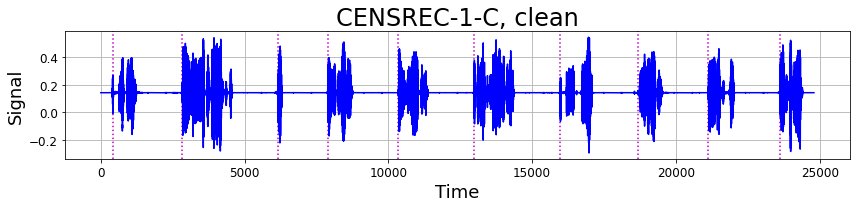

In [5]:
plt.figure(figsize=(12, 3))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, clean', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()

In [6]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:400]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

### Contrastive change point detection

#### With a linear class

In [8]:
p = 3

#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='poly', delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = 0.15 * np.maximum(np.max(S_stationary), 1e-4)
print('Threshold:', z)

#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_lin = []
false_alarms_lin = 0
not_detected_lin = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_lin = np.empty(0)

    # Initialization 
    st_lin = 0
    new_st_lin = 0

    while new_st_lin >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_lin, new_st_lin = compute_test_stat_linear(ds[st_lin + 1:], p, design='poly',\
                                                         delta_max=50, threshold=z)

        S_lin = np.append(S_lin, new_S_lin)

        if (st_lin < cp) and (new_st_lin < 0):
            not_detected_lin += 1

        if new_st_lin >= 0:
            st_lin += new_st_lin

        if st_lin >= cp:
            delays_lin += [st_lin - cp]
            change_point_lin = st_lin
            break

        else:
            false_alarms_lin += 1

delays_lin = np.array(delays_lin)

print('Linear class. Number of false alarms:', false_alarms_lin,\
      '; average delay:', np.round(np.mean(delays_lin), 4), '±', np.round(np.std(delays_lin), 4),\
      '; non-detected:', not_detected_lin)

Threshold: 2.5003850191276857
Test change points: [ 97 104 117 102 108 100]
Linear class. Number of false alarms: 0 ; average delay: 12.6667 ± 18.8296 ; non-detected: 0


#### With a class of neural networks

In [8]:
#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_nn(ds, n_epochs=20, delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = np.maximum(np.max(S_stationary), 1e-4)
print('Threshold:', z)

#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_nn = []
false_alarms_nn = 0
not_detected_nn = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_nn = np.empty(0)

    # Initialization 
    st_nn = 0
    new_st_nn = 0

    while new_st_nn >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_nn, new_st_nn = compute_test_stat_nn(ds[st_nn + 1:], n_epochs=20, delta_max=50, threshold=z)

        S_nn = np.append(S_nn, new_S_nn)

        if (st_nn < cp) and (new_st_nn < 0):
            not_detected_nn += 1

        if new_st_nn >= 0:
            st_nn += new_st_nn

        if st_nn >= cp:
            delays_nn += [st_nn - cp]
            change_point_nn = st_nn
            break

        else:
            false_alarms_nn += 1

delays_nn = np.array(delays_nn)

print('Neural network. Number of false alarms:', false_alarms_nn,\
      '; average delay:', np.round(np.mean(delays_nn), 4), '±', np.round(np.std(delays_nn), 4),\
      '; non-detected:', not_detected_nn)

Threshold: 0.00033938202823926303
Test change points: [ 97 104 117 102 108 100]
Neural network. Number of false alarms: 1 ; average delay: 2.5 ± 2.3629 ; non-detected: 0


### Fast contrastive change point detection algorithm

In [9]:
p = 3

# The list of hyperparameters
beta_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 2.5, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='hermite')
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 0.01)
    print('beta =', b, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_ftal = []
    false_alarms_ftal = 0
    not_detected_ftal = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_ftal = np.empty(0)

        # Initialization 
        st_ftal = 0
        new_st_ftal = 0

        while new_st_ftal >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                           design='hermite', threshold=z)

            S_ftal = np.append(S_ftal, new_S_ftal)

            if (st_ftal < cp) and (new_st_ftal < 0):
                not_detected_ftal += 1
                
            if new_st_ftal >= 0:
                st_ftal += new_st_ftal
                
            if st_ftal >= cp:
                delays_ftal += [st_ftal - cp]
                change_point_ftal = st_ftal
                break
            
            else:
                false_alarms_ftal += 1
                #print('i =', i, '. False alarm:', st_ftal)
                

        #print('Detected change point:', change_point_ftal)
    
    delays_ftal = np.array(delays_ftal)
    
    print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
          '; average delay:', np.round(np.mean(delays_ftal), 4), '±', np.round(np.std(delays_ftal), 4),\
          '; non-detected:', not_detected_ftal)

Validation change points: [110 115  97  91]
beta = 0.005 , threshold = 0.01
FTAL, beta = 0.005 . Number of false alarms: 2 ; average delay: 8.3333 ± 5.5578 ; non-detected: 1
beta = 0.01 , threshold = 0.01
FTAL, beta = 0.01 . Number of false alarms: 2 ; average delay: 7.6667 ± 5.4365 ; non-detected: 1
beta = 0.02 , threshold = 0.01
FTAL, beta = 0.02 . Number of false alarms: 2 ; average delay: 7.6667 ± 5.4365 ; non-detected: 1
beta = 0.05 , threshold = 0.01
FTAL, beta = 0.05 . Number of false alarms: 1 ; average delay: 11.25 ± 7.5952 ; non-detected: 0
beta = 0.1 , threshold = 0.01
FTAL, beta = 0.1 . Number of false alarms: 1 ; average delay: 14.75 ± 17.541 ; non-detected: 0
beta = 0.2 , threshold = 0.01
FTAL, beta = 0.2 . Number of false alarms: 1 ; average delay: 4.75 ± 7.0843 ; non-detected: 0
beta = 0.5 , threshold = 0.01
FTAL, beta = 0.5 . Number of false alarms: 2 ; average delay: 4.5 ± 4.3875 ; non-detected: 0
beta = 1 , threshold = 0.01
FTAL, beta = 1 . Number of false alarms: 1 

In [10]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.01
b = 0.5
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_ftal = []
false_alarms_ftal = 0
not_detected_ftal = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if (st_ftal < cp) and (new_st_ftal < 0):
            not_detected_ftal += 1

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal

        if st_ftal >= cp:
            delays_ftal += [st_ftal - cp]
            change_point_ftal = st_ftal
            break

        else:
            false_alarms_ftal += 1
            #print('i =', i, '. False alarm:', st_ftal)


    #print('Detected change point:', change_point_ftal)

delays_ftal = np.array(delays_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.round(np.mean(delays_ftal), 4), '±', np.round(np.std(delays_ftal), 4),\
      '; non-detected:', not_detected_ftal)

Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 0.5 . Number of false alarms: 1 ; average delay: 3.1667 ± 6.2026 ; non-detected: 0


### KLIEP

In [11]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 1e-4)
    print('sigma =', sigma, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_kliep = []
    false_alarms_kliep = 0
    not_detected_kliep = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_kliep = np.empty(0)

        # Initialization 
        st_kliep = 0
        new_st_kliep = 0

        while new_st_kliep >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                              window_size=50, sigma=sigma, threshold=z)

            S_kliep = np.append(S_kliep, new_S_kliep)

            if (st_kliep < cp) and (new_st_kliep < 0):
                not_detected_kliep += 1
                
            if new_st_kliep >= 0:
                st_kliep += new_st_kliep
                
            if st_kliep >= cp:
                delays_kliep += [st_kliep - cp]
                change_point_kliep = st_kliep
                break
            
            else:
                false_alarms_kliep += 1
                
    delays_kliep = np.array(delays_kliep)
    
    print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
          '; average delay:', np.round(np.mean(delays_kliep), 4), '±', np.round(np.std(delays_kliep), 4),\
          '; non-detected:', not_detected_kliep)

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 1.519689208966252
KLIEP, sigma = 0.01 . Number of false alarms: 4 ; average delay: 7.5 ± 2.5 ; non-detected: 2
sigma = 0.02 , threshold = 0.6148016064847331
KLIEP, sigma = 0.02 . Number of false alarms: 2 ; average delay: 5.3333 ± 4.1096 ; non-detected: 1
sigma = 0.025 , threshold = 0.17429109114606933
KLIEP, sigma = 0.025 . Number of false alarms: 2 ; average delay: 5.3333 ± 4.1096 ; non-detected: 1
sigma = 0.05 , threshold = 0.05715702996122803
KLIEP, sigma = 0.05 . Number of false alarms: 2 ; average delay: 5.3333 ± 4.1096 ; non-detected: 1
sigma = 0.075 , threshold = 0.017764161238812845
KLIEP, sigma = 0.075 . Number of false alarms: 2 ; average delay: 5.3333 ± 4.1096 ; non-detected: 1
sigma = 0.1 , threshold = 0.010328466146534916
KLIEP, sigma = 0.1 . Number of false alarms: 0 ; average delay: 5.5 ± 3.5707 ; non-detected: 0
sigma = 0.2 , threshold = 0.0001
KLIEP, sigma = 0.2 . Number of false alarms: 0 ; averag

In [12]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.6148016064847331
sigma = 0.02
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the delays array and
# the false alarms counter
delays_kliep = []
false_alarms_kliep = 0
not_detected_kliep = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if (st_kliep < cp) and (new_st_kliep < 0):
            not_detected_kliep += 1

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep

        if st_kliep >= cp:
            delays_kliep += [st_kliep - cp]
            change_point_kliep = st_kliep
            break

        else:
            false_alarms_kliep += 1

delays_kliep = np.array(delays_kliep)

print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.round(np.mean(delays_kliep), 4), '±', np.round(np.std(delays_kliep), 4),\
      '; non-detected:', not_detected_kliep)

Test change points: [ 97 104 117 102 108 100]
KLIEP, sigma = 0.02 . Number of false alarms: 0 ; average delay: 10.3333 ± 19.2325 ; non-detected: 0


### M-statistic

In [13]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 1e-4)
    print('sigma =', sigma, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_mmd = []
    false_alarms_mmd = 0
    not_detected_mmd = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_mmd = np.empty(0)

        # Initialization 
        st_mmd = 0
        new_st_mmd = 0

        while new_st_mmd >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                              window_size=50, sigma=sigma, threshold=z)

            S_mmd = np.append(S_mmd, new_S_mmd)

            if (st_mmd < cp) and (new_st_mmd < 0):
                not_detected_mmd += 1
                
            if new_st_mmd >= 0:
                st_mmd += new_st_mmd
                
            if st_mmd >= cp:
                delays_mmd += [st_mmd - cp]
                change_point_mmd = st_mmd
                break
            
            else:
                false_alarms_mmd += 1
                
    delays_mmd = np.array(delays_mmd)
    
    print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
          '; average delay:', np.round(np.mean(delays_mmd), 4), '±', np.round(np.std(delays_mmd), 4),\
          '; non-detected:', not_detected_mmd)

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 0.3285381833924303
M-statistic, sigma = 0.01 . Number of false alarms: 4 ; average delay: 7.0 ± 3.0 ; non-detected: 2
sigma = 0.02 , threshold = 0.10700780085969475
M-statistic, sigma = 0.02 . Number of false alarms: 4 ; average delay: 7.0 ± 3.0 ; non-detected: 2
sigma = 0.025 , threshold = 0.07079600630777064
M-statistic, sigma = 0.025 . Number of false alarms: 4 ; average delay: 7.0 ± 3.0 ; non-detected: 2
sigma = 0.05 , threshold = 0.01850294832210017
M-statistic, sigma = 0.05 . Number of false alarms: 2 ; average delay: 5.3333 ± 4.1096 ; non-detected: 1
sigma = 0.075 , threshold = 0.008291541624490731
M-statistic, sigma = 0.075 . Number of false alarms: 2 ; average delay: 5.3333 ± 4.1096 ; non-detected: 1
sigma = 0.1 , threshold = 0.004677456667637606
M-statistic, sigma = 0.1 . Number of false alarms: 2 ; average delay: 5.3333 ± 4.1096 ; non-detected: 1
sigma = 0.2 , threshold = 0.0011726192646438003
M-statistic

In [14]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.004677456667637606
sigma = 0.1
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the delays array and
# the false alarms counter
delays_mmd = []
false_alarms_mmd = 0
not_detected_mmd = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if (st_mmd < cp) and (new_st_mmd < 0):
            not_detected_mmd += 1

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd

        if st_mmd >= cp:
            delays_mmd += [st_mmd - cp]
            change_point_mmd = st_mmd
            break

        else:
            false_alarms_mmd += 1

delays_mmd = np.array(delays_mmd)

print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.round(np.mean(delays_mmd), 4), '±', np.round(np.std(delays_mmd), 4),\
      '; non-detected:', not_detected_mmd)

Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 0.1 . Number of false alarms: 0 ; average delay: 7.3333 ± 13.0597 ; non-detected: 0


## CENSREC-1-C, SNR 20

In [9]:
np.random.seed(1)
torch.manual_seed(1)

In [10]:
# Read the data
input_data = read('data/CENSREC/MAH_N1_SNR20.wav')
audio = input_data[1]

In [11]:
# Data preprocessing

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


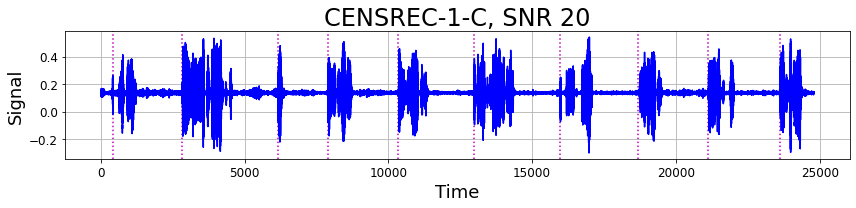

In [12]:
plt.figure(figsize=(12, 3))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, SNR 20', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()

In [13]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:400]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

### Contrastive change point detection

#### With a linear class

In [17]:
p = 3

#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='poly', delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = 0.6 * np.maximum(np.max(S_stationary), 1e-4)
print('Threshold:', z)

#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_lin = []
false_alarms_lin = 0
not_detected_lin = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_lin = np.empty(0)

    # Initialization 
    st_lin = 0
    new_st_lin = 0

    while new_st_lin >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_lin, new_st_lin = compute_test_stat_linear(ds[st_lin + 1:], p, design='poly',\
                                                         delta_max=50, threshold=z)

        S_lin = np.append(S_lin, new_S_lin)

        if (st_lin < cp) and (new_st_lin < 0):
            not_detected_lin += 1

        if new_st_lin >= 0:
            st_lin += new_st_lin

        if st_lin >= cp:
            delays_lin += [st_lin - cp]
            change_point_lin = st_lin
            break

        else:
            false_alarms_lin += 1

delays_lin = np.array(delays_lin)

print('Linear class. Number of false alarms:', false_alarms_lin,\
      '; average delay:', np.round(np.mean(delays_lin), 4), '±', np.round(np.std(delays_lin), 4),\
      '; non-detected:', not_detected_lin)

Threshold: 10.237580318376724
Test change points: [ 97 104 117 102 108 100]
Linear class. Number of false alarms: 0 ; average delay: 20.3333 ± 17.9227 ; non-detected: 0


#### With a class of neural networks

In [21]:
#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_nn(ds, n_epochs=20, delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = 0.6 * np.maximum(np.max(S_stationary), 1e-4)
print('Threshold:', z)

#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_nn = []
false_alarms_nn = 0
not_detected_nn = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_nn = np.empty(0)

    # Initialization 
    st_nn = 0
    new_st_nn = 0

    while new_st_nn >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_nn, new_st_nn = compute_test_stat_nn(ds[st_nn + 1:], n_epochs=20, delta_max=50, threshold=z)

        S_nn = np.append(S_nn, new_S_nn)

        if (st_nn < cp) and (new_st_nn < 0):
            not_detected_nn += 1

        if new_st_nn >= 0:
            st_nn += new_st_nn

        if st_nn >= cp:
            delays_nn += [st_nn - cp]
            change_point_nn = st_nn
            break

        else:
            false_alarms_nn += 1

delays_nn = np.array(delays_nn)

print('Neural network. Number of false alarms:', false_alarms_nn,\
      '; average delay:', np.round(np.mean(delays_nn), 4), '±', np.round(np.std(delays_nn), 4),\
      '; non-detected:', not_detected_nn)

Threshold: 0.002266459713229355
Test change points: [ 97 104 117 102 108 100]
Neural network. Number of false alarms: 0 ; average delay: 15.1667 ± 21.3574 ; non-detected: 0


### Fast contrastive change point detection algorithm

In [22]:
p = 3

# The list of hyperparameters
beta_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 2.5, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='hermite')
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 0.01)
    print('beta =', b, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_ftal = []
    false_alarms_ftal = 0
    not_detected_ftal = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_ftal = np.empty(0)

        # Initialization 
        st_ftal = 0
        new_st_ftal = 0

        while new_st_ftal >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                           design='hermite', threshold=z)

            S_ftal = np.append(S_ftal, new_S_ftal)

            if (st_ftal < cp) and (new_st_ftal < 0):
                not_detected_ftal += 1
                
            if new_st_ftal >= 0:
                st_ftal += new_st_ftal
                
            if st_ftal >= cp:
                delays_ftal += [st_ftal - cp]
                change_point_ftal = st_ftal
                break
            
            else:
                false_alarms_ftal += 1
                #print('i =', i, '. False alarm:', st_ftal)
                

        #print('Detected change point:', change_point_ftal)
    
    delays_ftal = np.array(delays_ftal)
    
    print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
          '; average delay:', np.round(np.mean(delays_ftal), 4), '±', np.round(np.std(delays_ftal), 4),\
          '; non-detected:', not_detected_ftal)

Validation change points: [110 115  97  91]
beta = 0.005 , threshold = 0.289985640072775
FTAL, beta = 0.005 . Number of false alarms: 0 ; average delay: 10.0 ± 4.4721 ; non-detected: 0
beta = 0.01 , threshold = 0.2890510568298323
FTAL, beta = 0.01 . Number of false alarms: 0 ; average delay: 7.0 ± 5.5227 ; non-detected: 0
beta = 0.02 , threshold = 0.1934299703664984
FTAL, beta = 0.02 . Number of false alarms: 0 ; average delay: 3.25 ± 2.7726 ; non-detected: 0
beta = 0.05 , threshold = 0.20232952667877802
FTAL, beta = 0.05 . Number of false alarms: 0 ; average delay: 10.75 ± 3.9607 ; non-detected: 0
beta = 0.1 , threshold = 0.11166584802103095
FTAL, beta = 0.1 . Number of false alarms: 0 ; average delay: 7.5 ± 6.1033 ; non-detected: 0
beta = 0.2 , threshold = 0.07177206384994231
FTAL, beta = 0.2 . Number of false alarms: 1 ; average delay: 23.25 ± 26.9014 ; non-detected: 0
beta = 0.5 , threshold = 0.0643961020221287
FTAL, beta = 0.5 . Number of false alarms: 1 ; average delay: 20.25 ± 2

In [23]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.1934299703664984
b = 0.02
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_ftal = []
false_alarms_ftal = 0
not_detected_ftal = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if (st_ftal < cp) and (new_st_ftal < 0):
            not_detected_ftal += 1

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal

        if st_ftal >= cp:
            delays_ftal += [st_ftal - cp]
            change_point_ftal = st_ftal
            break

        else:
            false_alarms_ftal += 1
            #print('i =', i, '. False alarm:', st_ftal)


    #print('Detected change point:', change_point_ftal)

delays_ftal = np.array(delays_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.round(np.mean(delays_ftal), 4), '±', np.round(np.std(delays_ftal), 4),\
      '; non-detected:', not_detected_ftal)

Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 0.02 . Number of false alarms: 0 ; average delay: 18.5 ± 19.721 ; non-detected: 0


### KLIEP

In [24]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 1e-4)
    print('sigma =', sigma, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_kliep = []
    false_alarms_kliep = 0
    not_detected_kliep = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_kliep = np.empty(0)

        # Initialization 
        st_kliep = 0
        new_st_kliep = 0

        while new_st_kliep >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                              window_size=50, sigma=sigma, threshold=z)

            S_kliep = np.append(S_kliep, new_S_kliep)

            if (st_kliep < cp) and (new_st_kliep < 0):
                not_detected_kliep += 1
                
            if new_st_kliep >= 0:
                st_kliep += new_st_kliep
                
            if st_kliep >= cp:
                delays_kliep += [st_kliep - cp]
                change_point_kliep = st_kliep
                break
            
            else:
                false_alarms_kliep += 1
                
    delays_kliep = np.array(delays_kliep)
    
    print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
          '; average delay:', np.round(np.mean(delays_kliep), 4), '±', np.round(np.std(delays_kliep), 4),\
          '; non-detected:', not_detected_kliep)

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 27.711510863649302
KLIEP, sigma = 0.01 . Number of false alarms: 2 ; average delay: 11.3333 ± 8.2192 ; non-detected: 1
sigma = 0.02 , threshold = 13.35628849967587
KLIEP, sigma = 0.02 . Number of false alarms: 2 ; average delay: 11.0 ± 7.7889 ; non-detected: 1
sigma = 0.025 , threshold = 9.2420379539687
KLIEP, sigma = 0.025 . Number of false alarms: 2 ; average delay: 10.3333 ± 6.9442 ; non-detected: 1
sigma = 0.05 , threshold = 2.569042672329687
KLIEP, sigma = 0.05 . Number of false alarms: 2 ; average delay: 9.6667 ± 5.3125 ; non-detected: 1
sigma = 0.075 , threshold = 1.173071131168887
KLIEP, sigma = 0.075 . Number of false alarms: 0 ; average delay: 9.5 ± 5.0249 ; non-detected: 0
sigma = 0.1 , threshold = 0.6869535377995625
KLIEP, sigma = 0.1 . Number of false alarms: 0 ; average delay: 11.0 ± 3.937 ; non-detected: 0
sigma = 0.2 , threshold = 0.17712006587797102
KLIEP, sigma = 0.2 . Number of false alarms: 0 ; a

In [25]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 1.173071131168887
sigma = 0.075
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the delays array and
# the false alarms counter
delays_kliep = []
false_alarms_kliep = 0
not_detected_kliep = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if (st_kliep < cp) and (new_st_kliep < 0):
            not_detected_kliep += 1

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep

        if st_kliep >= cp:
            delays_kliep += [st_kliep - cp]
            change_point_kliep = st_kliep
            break

        else:
            false_alarms_kliep += 1

delays_kliep = np.array(delays_kliep)

print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.round(np.mean(delays_kliep), 4), '±', np.round(np.std(delays_kliep), 4),\
      '; non-detected:', not_detected_kliep)

Test change points: [ 97 104 117 102 108 100]
KLIEP, sigma = 0.075 . Number of false alarms: 0 ; average delay: 21.0 ± 21.1975 ; non-detected: 0


### M-statistic

In [26]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 1e-4)
    print('sigma =', sigma, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_mmd = []
    false_alarms_mmd = 0
    not_detected_mmd = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_mmd = np.empty(0)

        # Initialization 
        st_mmd = 0
        new_st_mmd = 0

        while new_st_mmd >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                              window_size=50, sigma=sigma, threshold=z)

            S_mmd = np.append(S_mmd, new_S_mmd)

            if (st_mmd < cp) and (new_st_mmd < 0):
                not_detected_mmd += 1
                
            if new_st_mmd >= 0:
                st_mmd += new_st_mmd
                
            if st_mmd >= cp:
                delays_mmd += [st_mmd - cp]
                change_point_mmd = st_mmd
                break
            
            else:
                false_alarms_mmd += 1
                
    delays_mmd = np.array(delays_mmd)
    
    print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
          '; average delay:', np.round(np.mean(delays_mmd), 4), '±', np.round(np.std(delays_mmd), 4),\
          '; non-detected:', not_detected_mmd)

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 5.869495777337102
M-statistic, sigma = 0.01 . Number of false alarms: 2 ; average delay: 17.3333 ± 9.7411 ; non-detected: 1
sigma = 0.02 , threshold = 2.668381121510442
M-statistic, sigma = 0.02 . Number of false alarms: 2 ; average delay: 12.3333 ± 11.1455 ; non-detected: 1
sigma = 0.025 , threshold = 1.7745847740930265
M-statistic, sigma = 0.025 . Number of false alarms: 2 ; average delay: 11.3333 ± 9.8432 ; non-detected: 1
sigma = 0.05 , threshold = 0.44740948311473083
M-statistic, sigma = 0.05 . Number of false alarms: 2 ; average delay: 9.6667 ± 7.7603 ; non-detected: 1
sigma = 0.075 , threshold = 0.20096895932626715
M-statistic, sigma = 0.075 . Number of false alarms: 2 ; average delay: 9.6667 ± 6.1283 ; non-detected: 1
sigma = 0.1 , threshold = 0.11883796863002456
M-statistic, sigma = 0.1 . Number of false alarms: 2 ; average delay: 9.3333 ± 5.7349 ; non-detected: 1
sigma = 0.2 , threshold = 0.017586725390910

In [27]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.0015690352677189098
sigma = 0.5
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the delays array and
# the false alarms counter
delays_mmd = []
false_alarms_mmd = 0
not_detected_mmd = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if (st_mmd < cp) and (new_st_mmd < 0):
            not_detected_mmd += 1

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd

        if st_mmd >= cp:
            delays_mmd += [st_mmd - cp]
            change_point_mmd = st_mmd
            break

        else:
            false_alarms_mmd += 1

delays_mmd = np.array(delays_mmd)

print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.round(np.mean(delays_mmd), 4), '±', np.round(np.std(delays_mmd), 4),\
      '; non-detected:', not_detected_mmd)

Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 0.5 . Number of false alarms: 0 ; average delay: 17.3333 ± 20.1301 ; non-detected: 0


## CENSREC-1-C, SNR 15

In [28]:
np.random.seed(1)
torch.manual_seed(1)

In [29]:
# Read the data
input_data = read('data/CENSREC/MAH_N1_SNR15.wav')
audio = input_data[1]

In [30]:
# Data preprocessing

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


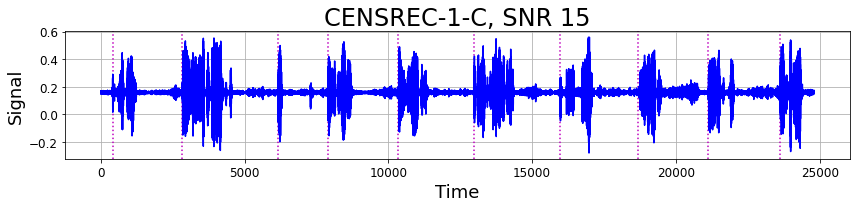

In [31]:
plt.figure(figsize=(12, 3))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, SNR 15', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()

In [32]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:400]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

### Contrastive change point

#### With a linear class

In [33]:
p = 3

#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='poly', delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = 1.35 * np.maximum(np.max(S_stationary), 1e-4)
print('Threshold:', z)

#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_lin = []
false_alarms_lin = 0
not_detected_lin = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_lin = np.empty(0)

    # Initialization 
    st_lin = 0
    new_st_lin = 0

    while new_st_lin >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_lin, new_st_lin = compute_test_stat_linear(ds[st_lin + 1:], p, design='poly',\
                                                         delta_max=50, threshold=z)

        S_lin = np.append(S_lin, new_S_lin)

        if (st_lin < cp) and (new_st_lin < 0):
            not_detected_lin += 1

        if new_st_lin >= 0:
            st_lin += new_st_lin

        if st_lin >= cp:
            delays_lin += [st_lin - cp]
            change_point_lin = st_lin
            break

        else:
            false_alarms_lin += 1

delays_lin = np.array(delays_lin)

print('Linear class. Number of false alarms:', false_alarms_lin,\
      '; average delay:', np.round(np.mean(delays_lin), 4), '±', np.round(np.std(delays_lin), 4),\
      '; non-detected:', not_detected_lin)

Threshold: 0.4117426377125087
Test change points: [ 97 104 117 102 108 100]
Linear class. Number of false alarms: 1 ; average delay: 9.1667 ± 10.976 ; non-detected: 0


#### With a class of neural networks

In [34]:
#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_nn(ds, n_epochs=20, delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = 2 * np.maximum(np.max(S_stationary), 1e-4)
print('Threshold:', z)


#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]


#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_nn = []
false_alarms_nn = 0
not_detected_nn = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_nn = np.empty(0)

    # Initialization 
    st_nn = 0
    new_st_nn = 0

    while new_st_nn >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_nn, new_st_nn = compute_test_stat_nn(ds[st_nn + 1:], n_epochs=20, delta_max=50, threshold=z)

        S_nn = np.append(S_nn, new_S_nn)

        if (st_nn < cp) and (new_st_nn < 0):
            not_detected_nn += 1

        if new_st_nn >= 0:
            st_nn += new_st_nn

        if st_nn >= cp:
            delays_nn += [st_nn - cp]
            change_point_nn = st_nn
            break

        else:
            false_alarms_nn += 1

delays_nn = np.array(delays_nn)

print('Neural network. Number of false alarms:', false_alarms_nn,\
      '; average delay:', np.round(np.mean(delays_nn), 4), '±', np.round(np.std(delays_nn), 4),\
      '; non-detected:', not_detected_nn)

Threshold: 0.003999213084098475
Test change points: [ 97 104 117 102 108 100]
Neural network. Number of false alarms: 1 ; average delay: 8.3333 ± 2.7487 ; non-detected: 0


### Fast contrastive change point detection algorithm

In [37]:
p = 3

# The list of hyperparameters
beta_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 2.5, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='hermite')
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 0.01)
    print('beta =', b, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_ftal = []
    false_alarms_ftal = 0
    not_detected_ftal = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_ftal = np.empty(0)

        # Initialization 
        st_ftal = 0
        new_st_ftal = 0

        while new_st_ftal >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                           design='hermite', threshold=z)

            S_ftal = np.append(S_ftal, new_S_ftal)

            if (st_ftal < cp) and (new_st_ftal < 0):
                not_detected_ftal += 1
                
            if new_st_ftal >= 0:
                st_ftal += new_st_ftal
                
            if st_ftal >= cp:
                delays_ftal += [st_ftal - cp]
                change_point_ftal = st_ftal
                break
            
            else:
                false_alarms_ftal += 1
                #print('i =', i, '. False alarm:', st_ftal)
                

        #print('Detected change point:', change_point_ftal)
    
    delays_ftal = np.array(delays_ftal)
    
    print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
          '; average delay:', np.round(np.mean(delays_ftal), 4), '±', np.round(np.std(delays_ftal), 4),\
          '; non-detected:', not_detected_ftal)

Validation change points: [110 115  97  91]
beta = 0.005 , threshold = 0.15516625597660044
FTAL, beta = 0.005 . Number of false alarms: 0 ; average delay: 9.0 ± 5.244 ; non-detected: 0
beta = 0.01 , threshold = 0.1802302227839938
FTAL, beta = 0.01 . Number of false alarms: 0 ; average delay: 6.75 ± 6.6097 ; non-detected: 0
beta = 0.02 , threshold = 0.023518716071721905
FTAL, beta = 0.02 . Number of false alarms: 3 ; average delay: 12.25 ± 7.1545 ; non-detected: 0
beta = 0.05 , threshold = 0.04512578191482511
FTAL, beta = 0.05 . Number of false alarms: 2 ; average delay: 11.75 ± 8.6422 ; non-detected: 0
beta = 0.1 , threshold = 0.01
FTAL, beta = 0.1 . Number of false alarms: 2 ; average delay: 6.75 ± 8.2576 ; non-detected: 0
beta = 0.2 , threshold = 0.03035557991555222
FTAL, beta = 0.2 . Number of false alarms: 1 ; average delay: 7.0 ± 8.3964 ; non-detected: 0
beta = 0.5 , threshold = 0.01880282223594478
FTAL, beta = 0.5 . Number of false alarms: 2 ; average delay: 6.5 ± 6.3443 ; non-de

In [38]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.1802302227839938
b = 0.01
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
# Initialization of the delays array and
# the false alarms counter
delays_ftal = []
false_alarms_ftal = 0
not_detected_ftal = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if (st_ftal < cp) and (new_st_ftal < 0):
            not_detected_ftal += 1

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal

        if st_ftal >= cp:
            delays_ftal += [st_ftal - cp]
            change_point_ftal = st_ftal
            break

        else:
            false_alarms_ftal += 1
            #print('i =', i, '. False alarm:', st_ftal)


    #print('Detected change point:', change_point_ftal)

delays_ftal = np.array(delays_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.round(np.mean(delays_ftal), 4), '±', np.round(np.std(delays_ftal), 4),\
      '; non-detected:', not_detected_ftal)

Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 0.01 . Number of false alarms: 1 ; average delay: 12.5 ± 8.9209 ; non-detected: 0


### KLIEP

In [39]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 1e-4)
    print('sigma =', sigma, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_kliep = []
    false_alarms_kliep = 0
    not_detected_kliep = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_kliep = np.empty(0)

        # Initialization 
        st_kliep = 0
        new_st_kliep = 0

        while new_st_kliep >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                              window_size=50, sigma=sigma, threshold=z)

            S_kliep = np.append(S_kliep, new_S_kliep)

            if (st_kliep < cp) and (new_st_kliep < 0):
                not_detected_kliep += 1
                
            if new_st_kliep >= 0:
                st_kliep += new_st_kliep
                
            if st_kliep >= cp:
                delays_kliep += [st_kliep - cp]
                change_point_kliep = st_kliep
                break
            
            else:
                false_alarms_kliep += 1
                
    delays_kliep = np.array(delays_kliep)
    
    print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
          '; average delay:', np.round(np.mean(delays_kliep), 4), '±', np.round(np.std(delays_kliep), 4),\
          '; non-detected:', not_detected_kliep)

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 4.700016427338852
KLIEP, sigma = 0.01 . Number of false alarms: 4 ; average delay: 8.0 ± 2.0 ; non-detected: 2
sigma = 0.02 , threshold = 1.4649383493061257
KLIEP, sigma = 0.02 . Number of false alarms: 4 ; average delay: 8.0 ± 2.0 ; non-detected: 2
sigma = 0.025 , threshold = 0.9784163671548415
KLIEP, sigma = 0.025 . Number of false alarms: 4 ; average delay: 8.0 ± 2.0 ; non-detected: 2
sigma = 0.05 , threshold = 0.29305296468755854
KLIEP, sigma = 0.05 . Number of false alarms: 2 ; average delay: 9.3333 ± 5.7349 ; non-detected: 1
sigma = 0.075 , threshold = 0.14065201130733002
KLIEP, sigma = 0.075 . Number of false alarms: 2 ; average delay: 10.3333 ± 4.4969 ; non-detected: 1
sigma = 0.1 , threshold = 0.07919147895203986
KLIEP, sigma = 0.1 . Number of false alarms: 0 ; average delay: 9.25 ± 4.657 ; non-detected: 0
sigma = 0.2 , threshold = 0.017768510402096007
KLIEP, sigma = 0.2 . Number of false alarms: 0 ; averag

In [40]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.07919147895203986
sigma = 0.1

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the delays array and
# the false alarms counter
delays_kliep = []
false_alarms_kliep = 0
not_detected_kliep = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if (st_kliep < cp) and (new_st_kliep < 0):
            not_detected_kliep += 1

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep

        if st_kliep >= cp:
            delays_kliep += [st_kliep - cp]
            change_point_kliep = st_kliep
            break

        else:
            false_alarms_kliep += 1

delays_kliep = np.array(delays_kliep)

print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.round(np.mean(delays_kliep), 4), '±', np.round(np.std(delays_kliep), 4),\
      '; non-detected:', not_detected_kliep)

Test change points: [ 97 104 117 102 108 100]
KLIEP, sigma = 0.1 . Number of false alarms: 0 ; average delay: 20.5 ± 21.5542 ; non-detected: 0


### M-statistic

In [41]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.maximum(np.max(S_stationary), 1e-4)
    print('sigma =', sigma, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the delays array and
    # the false alarms counter
    delays_mmd = []
    false_alarms_mmd = 0
    not_detected_mmd = 0
    
    for i in range(len(change_points_val)):
        
        # Data
        ds = data_val[i]
        # Change point
        cp = change_points_val[i]
        
        # Initialization of the test statistic
        S_mmd = np.empty(0)

        # Initialization 
        st_mmd = 0
        new_st_mmd = 0

        while new_st_mmd >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                              window_size=50, sigma=sigma, threshold=z)

            S_mmd = np.append(S_mmd, new_S_mmd)

            if (st_mmd < cp) and (new_st_mmd < 0):
                not_detected_mmd += 1
                
            if new_st_mmd >= 0:
                st_mmd += new_st_mmd
                
            if st_mmd >= cp:
                delays_mmd += [st_mmd - cp]
                change_point_mmd = st_mmd
                break
            
            else:
                false_alarms_mmd += 1
                
    delays_mmd = np.array(delays_mmd)
    
    print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
          '; average delay:', np.round(np.mean(delays_mmd), 4), '±', np.round(np.std(delays_mmd), 4),\
          '; non-detected:', not_detected_mmd)

Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 5.982961992301529
M-statistic, sigma = 0.01 . Number of false alarms: 2 ; average delay: 17.0 ± 7.2572 ; non-detected: 1
sigma = 0.02 , threshold = 1.297900058086973
M-statistic, sigma = 0.02 . Number of false alarms: 4 ; average delay: 10.5 ± 0.5 ; non-detected: 2
sigma = 0.025 , threshold = 0.6695937924457004
M-statistic, sigma = 0.025 . Number of false alarms: 4 ; average delay: 8.5 ± 1.5 ; non-detected: 2
sigma = 0.05 , threshold = 0.09319636442718547
M-statistic, sigma = 0.05 . Number of false alarms: 4 ; average delay: 8.0 ± 2.0 ; non-detected: 2
sigma = 0.075 , threshold = 0.03388731413178611
M-statistic, sigma = 0.075 . Number of false alarms: 4 ; average delay: 8.0 ± 2.0 ; non-detected: 2
sigma = 0.1 , threshold = 0.01766636928903212
M-statistic, sigma = 0.1 . Number of false alarms: 4 ; average delay: 8.0 ± 2.0 ; non-detected: 2
sigma = 0.2 , threshold = 0.004419319698569515
M-statistic, sigma = 0.2 . Numb

In [42]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z = 0.0001
sigma = 2
    
# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Initialization of the delays array and
# the false alarms counter
delays_mmd = []
false_alarms_mmd = 0
not_detected_mmd = 0

for i in range(len(change_points_test)):

    # Data
    ds = data_test[i]
    # Change point
    cp = change_points_test[i]

    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if (st_mmd < cp) and (new_st_mmd < 0):
            not_detected_mmd += 1

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd

        if st_mmd >= cp:
            delays_mmd += [st_mmd - cp]
            change_point_mmd = st_mmd
            break

        else:
            false_alarms_mmd += 1

delays_mmd = np.array(delays_mmd)

print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.round(np.mean(delays_mmd), 4), '±', np.round(np.std(delays_mmd), 4),\
      '; non-detected:', not_detected_mmd)

Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 2 . Number of false alarms: 0 ; average delay: 14.8333 ± 19.3513 ; non-detected: 0
